In [1]:
ASSETS_DIR = "/content/drive/MyDrive/Colab Notebooks/assets"

In [2]:
from __future__ import annotations

import numpy as np
import pandas as pd

from dataclasses import dataclass, field

In [3]:
@dataclass
class Node:
  indexes: list[int] = field(default_factory=list)
  childs: list[Node] = field(default_factory=list)
  branch: str = ""
  key: str = ""

  def __show(self, indexes, branch, childs, key, r=0, c=0, x=0):
    print(c * '\t', indexes, end=" ")
    print("#" + str(branch) if branch else "", end=" ")
    print("@" + str(key) if key else "", end="\n")

    if len(childs) == 0:
      return
    else:
      c += 1

    for i in childs:
      r += 1
      x = c * r + 1
      self.__show(i.indexes, i.branch, i.childs, i.key, r, c, x)

  @property
  def show(self):
    self.__show(self.indexes, self.branch, self.childs, self.key)

In [4]:
def exclude_from(df, exclude_list):
  if len(exclude_list) > 0:
    return df.loc[:, ~df.columns.isin(exclude_list)]
  return df

---
# ID3

In [ ]:
def entropy(s):
    p = -s.value_counts() \
          .div(s.count()) \
          .agg(lambda x: x*np.log2(x)) \
          .sum()

    return p

In [ ]:
def gain(s, col, target):
    p_target = entropy(s[target])
    keys = s[col].drop_duplicates()
    entropies = keys.apply(lambda _: (_,
                                      entropy(s[target][s[col][s[col] == _].index])))
    ratios = s[col].value_counts().div(len(s))
    res = np.subtract(p_target,
                      entropies.apply(lambda _: ratios.loc[_[0]] * _[1])
                               .sum())

    return col, res

In [ ]:
def id3(s, *, df=None, target, exclude, verbose=False):
    node = Node()

    # stopping case
    if df is not None and len(df) == 0:
        return

    # store first dataframe
    if df is None:
        df = s.copy()

    node.indexes = list(s.index)

    # remove excluded columns from dataframe
    s = exclude_from(s, exclude)
    #if len(exclude) > 0:
    #    s = s.loc[:, ~s.columns.isin(exclude)]

    columns = s.columns.drop(labels=[target])

    gains = columns.map(lambda x: gain(s, x, target)) \
                   .to_frame(index=False) \
                   .set_index(0)

    if verbose:
      print("\nSET:\n\n", df.loc[s.index])
      print("\nGAINS: \n", gains)

    if gains.empty or len(df[target].value_counts()) == 1:
        if verbose:
          print("\n\nLEAF<<<\n\n")
        node.branch = df[target].values[0]
        return node

    next_branch = gains.idxmax().values[0]
    node.branch = next_branch

    if verbose:
      print("\nNEXT BRANCH: ", next_branch)

    next_S = df[next_branch].drop_duplicates() \
                            .apply(lambda _: df.loc[df[next_branch][df[next_branch] == _] \
                                               .index])

    for k, v in enumerate(next_S):
      if verbose:
        print(f"epoch @{k}")
      #print(v[next_branch].values[0])
      n = id3(v, df=df.loc[v.index], target=target, exclude=[*exclude, next_branch])
      n.key = v[next_branch].values[0]
      node.childs.append(n)

    return node


In [ ]:
df = pd.read_csv(ASSETS_DIR + "/weather.csv")
target = "play" #@param {type: "string"}
exclude = ["id"] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] #outlook 
	 [0, 1, 7, 8, 10] #humidity @sunny
		 [0, 1, 7]  @high
		 [8, 10]  @normal
	 [2, 6, 11, 12]  @overcast
	 [3, 4, 5, 9, 13] #windy @rainy
		 [3, 4, 9]  
		 [5, 13]  @True


---

In [ ]:
df = pd.read_csv(ASSETS_DIR + "/job.csv")
target = "risk" #@param {type: "string"}
exclude = ["customer"] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target, verbose=False)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #debt 
	 [0, 1, 2]  @High
	 [3, 4, 5, 6, 7, 8, 9] #revenue @Low
		 [3, 4, 7, 8] #status @Low
			 [3, 7]  @Employee
			 [4, 8]  @Employeer
		 [5, 6, 9]  @High


---

In [ ]:
df = pd.read_csv(ASSETS_DIR + "/tennis.csv")
target = "play" #@param {type: "string"}
exclude = [] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] #outlook 
	 [0, 1, 7, 8, 10] #humidity @sunny
		 [0, 1, 7]  @high
		 [8, 10]  @normal
	 [2, 6, 11, 12]  @overcast
	 [3, 4, 5, 9, 13] #windy @rainy
		 [3, 4, 9]  @weak
		 [5, 13]  @strong


---

In [ ]:
df = pd.read_csv(ASSETS_DIR + "/monks.csv")
target = "has_tie" #@param {type: "string"}
exclude = [] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target)
tree.show

In [ ]:
data = {
    "hava": ["Gunesli", "Gunesli", "Ruzgarli", "Yagmurlu", "Yagmurlu", "Yagmurlu", "Ruzgarli", "Ruzgarli", "Ruzgarli", "Gunesli"],
    "aile": ["Evet", "Hayir", "Evet", "Evet", "Hayir", "Evet", "Hayir", "Hayir", "Evet", "Hayir"],
    "para": ["Z", "Z", "Z", "F", "Z", "F", "F", "Z", "Z", "Z"],
    "karar": ["sinema", "tenis", "sinema", "sinema", "ev", "sinema", "sinema", "alisveris", "sinema", "tenis"]
}

df = pd.DataFrame(data)

target = "karar" #@param {type: "string"}
exclude = [] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] #hava 
	 [0, 1, 9] #aile @Gunesli
		 [0] #sinema @Evet
		 [1, 9] #tenis @Hayir
	 [2, 6, 7, 8] #aile @Ruzgarli
		 [2, 8] #sinema @Evet
		 [6, 7] #para @Hayir
			 [6] #sinema @F
			 [7] #alisveris @Z
	 [3, 4, 5] #aile @Yagmurlu
		 [3, 5] #sinema @Evet
		 [4] #ev @Hayir


---

---
# C4.5

In [ ]:
data = {
    "A1": ['a', 'a', 'a', 'a', 'a', 'b', 'b', 'b', 'b', 'c', 'c', 'c', 'c', 'c'],
    "A2": [70, 90, 85, 95, 70, 90, 78, 65, 75, 80, 70, 80, 70, 96],
    "A3": [True, True, False, False, False, True, False, True, False, True, True, False, False, False],
    "class": ["class1", "class2", "class2", "class2", "class1", "class1","class1","class1","class1", "class2", "class2", "class1", "class1","class1",]
}

df = pd.DataFrame(data)
threshold = df['A2'].drop_duplicates() \
                    .sort_values() \
                    .median()
df['A2'] = df['A2'].apply(lambda x: 'lte' if x <= threshold else 'gt')
df[:3]

,A1,A2,A3,class
0,a,lte,True,class1
1,a,gt,True,class2
2,a,gt,False,class2


In [ ]:
target = "class" #@param {type: "string"}
exclude = [] #@param

# 1st epoch
tree = id3(df, exclude=exclude, target=target, verbose=False)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13] #A1 
	 [0, 1, 2, 3, 4] #A2 @a
		 [0, 4]  @lte
		 [1, 2, 3]  @gt
	 [5, 6, 7, 8]  @b
	 [9, 10, 11, 12, 13] #A3 @c
		 [9, 10]  @True
		 [11, 12, 13]  


---
# TWOING

In [ ]:
a = {
    "salary": ["N", "H", "L", "H", "L", "H", "L", "H", "L", "H", "L"],
     "exp": ["M", "N", "N", "M", "M", "G", "G", "M", "M", "G", "G"],
     "major": ["expert", "expert", "manager", "manager","manager","manager","manager", "expert", "expert","expert","expert"],
     "satisfied": ["Y", "Y", "Y", "Y", "Y", "Y", "Y", "N", "N","N","N"]
}

target = "satisfied"
exclude = []

df = pd.DataFrame(a)
df

,salary,exp,major,satisfied
0,N,M,expert,Y
1,H,N,expert,Y
2,L,N,manager,Y
3,H,M,manager,Y
4,L,M,manager,Y
5,H,G,manager,Y
6,L,G,manager,Y
7,H,M,expert,N
8,L,M,expert,N
9,H,G,expert,N


In [ ]:
import itertools as it

def get_permutations(df):
  permutations = {}
  for _ in df.iloc[:, :-1]:
      p = pd.DataFrame(it.permutations(df[_].unique())) \
            .drop_duplicates(subset=[0]) \
            .reset_index(drop=True)
      permutations[_] = p

  return permutations

In [ ]:
import collections

def twoing(df, *, target, exclude=[]):
  def solve(p, k):
    def P(r):
      l = df[df[k].isin(r)]
      ll = len(l)
      pl = np.divide(ll, len(df))
      pr = l.groupby(target) \
            .count()[k] \
            .apply(lambda x: np.divide(x, ll))
  
      #pr.index = pr.index.set_names([''])
      #pr = pd.DataFrame(pr)
      #pr['p'] = pr[k].apply(lambda x: np.divide(x, ll))
  
      return ll, pl, pr

    gains = []
    for i in p:
      L, R = p.iloc[i, :1], p.iloc[i, 1:]
      bl, lpl, lpr = P(L)
      br, rpl, rpr = P(R)
  
      #print(f"P-LEFT={lpl:.2f} \t P-RIGHT={rpl:.2f}")
  
      val = (2 * lpl * rpl * lpr.sub(rpr, fill_value=0.0)
                                .abs() 
                                .sum())
      
      gains.append(val)
      #print(f"{val=:.2f}")
      #print('\n\n' + 32*'-')

    return gains

  # stopping case
  if df is not None and len(df) == 0:
      return

  node = Node()
  node.indexes = list(df.index)

  excluded_df = exclude_from(df, exclude)
  #print(excluded_df)

  permutations = get_permutations(excluded_df)
  gains = collections.defaultdict(list)
  for k, v in permutations.items():
    e = solve(v, k)
    gains[k] = e

  if len(gains) == 0 or len(df[target].value_counts()) == 1:
      node.key = df[target].values[0]
      return node
  
  next_branch = max(gains, key=gains.get)
  next_branch_index = np.argmax(gains[next_branch])
  #print(next_branch_index)
  node.branch = next_branch

  #print(next_branch)
  t = permutations[next_branch]
  #print(t)
  L, R = (t.iloc[next_branch_index, :1], 
          t.iloc[next_branch_index, 1:])
  #print(L, R)
  #input(">>>")

  exclude = [*exclude, next_branch]
  ln = twoing(df[df[next_branch].isin(L)], target=target, exclude=exclude)
  rn = twoing(df[df[next_branch].isin(R)], target=target, exclude=exclude)

  node.childs.append(ln) 
  node.childs.append(rn) 

  #for i in permutations[next_branch][0]:
  #  n = twoing(df[df[next_branch] == i], target=target, exclude=[*exclude, next_branch])
  #  node.childs.append(n)

  return node

In [ ]:
tree = twoing(df, target="satisfied")
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #major 
	 [0, 1, 7, 8, 9, 10] #salary 
		 [0]  @Y
		 [1, 7, 8, 9, 10] #exp 
			 [1]  @Y
			 [7, 8, 9, 10]  @N
	 [2, 3, 4, 5, 6]  @Y


In [ ]:
df = pd.read_excel(ASSETS_DIR + '/twoing.xls')
target = "Memnun"
exclude = ["Müşteri"]

tree = twoing(df, target=target, exclude=exclude)
tree.show

 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #Sektör 
	 [0, 1, 7, 8, 9, 10] #Gelir 
		 [0]  @Evet
		 [1, 7, 8, 9, 10] #Eğitim 
			 [1]  @Evet
			 [7, 8, 9, 10]  @Hayır
	 [2, 3, 4, 5, 6]  @Evet


---
# K-Nearest Neighbors 

In [ ]:
def knn(df, *, p, k, target):
  excluded_df = df[p.columns]

  normalize = (lambda x: (x - excluded_df.min()) 
                      / (excluded_df.max() - excluded_df.min()))
  
  normalized_df = normalize(excluded_df)
  normalized_p = normalize(p)

  df['d'] = (
    df[p.columns].sub(p.squeeze())
                 .agg(np.square)
                 .sum(axis=1)
                 .agg(np.sqrt)
  )

  neighbors = df.sort_values(by='d')[:k]
  belongs = (
      neighbors.groupby(target)
               .count()
               .idxmax()[0]
  )

  return belongs

In [ ]:
data = {
    "x1": [2, 3, 3, 4, 5, 6, 7, 9, 11, 10],
    "x2": [4, 6, 4, 10, 8, 3, 9, 7, 7, 2],
    "y": ['Bad', 'Good', 'Good', 'Bad', 'Bad', 'Good', 'Good', 'Bad', 'Bad', 'Bad']
}

p = pd.DataFrame({
    'x1': [8],
    'x2': [4],
})

df = pd.DataFrame(data)
knn(df, p=p, k=4, target='y')

'Bad'

In [ ]:
data = {
    "x1": [10, 8, 18, 12, 3],
    "x2": [5, 2, 16, 15, 15],
    "x3": [19, 4, 6, 8, 15],
    "y": ['Yes', 'No', 'No', 'Yes', 'Yes']
}

p = pd.DataFrame({
    'x1': [7],
    'x2': [8],
    'x3': [5],
})

df = pd.DataFrame(data)
knn(df, p=p, k=3, target='y')

'Yes'

---
# K-Means

In [9]:
def kmean(df, *, k):
  columns = df.columns[1:]
  clusters = [i for i in range(0, k)]
  p = [1/len(clusters)]*len(clusters)

  df['cluster'] = np.random.choice(clusters,
                                  len(df),
                                  p=p)


  def solve(cpdf, least_mse=None):
    centers = cpdf.groupby('cluster').mean(numeric_only=True)

    mse = cpdf.groupby('cluster') \
              .apply(lambda x: np.square(x - x.mean(numeric_only=True)).sum()) \
              .sum(axis=1) \
              .sum()

    if least_mse and mse >= least_mse:
      return cpdf
  
    distances = cpdf.apply(lambda x: np.square(centers - x)
                                        .sum(axis=1)**0.5, axis=1)

    cpdf['cluster'] = distances.T.idxmin()

    return solve(cpdf, mse)

  cpdf = df.copy()
  return solve(cpdf)

data = {
    "x": [4, 8, 5, 10, 11, 4, 12, 2, 3, 20, 19, 19, 15, 6, 1],
    "y": [2, 4, 1, 6, 8, 3, 8, 2, 3, 20, 18, 21, 35, 32, 45],
}

df = pd.DataFrame(data)

#df = pd.read_csv(ASSETS_DIR + '/housing.csv')
#df = load_iris(as_frame=True).data
res_df = kmean(df.copy(), k=3)
res_df

,x,y,cluster
0,4,2,1
1,8,4,1
2,5,1,1
3,10,6,1
4,11,8,1
5,4,3,1
6,12,8,1
7,2,2,1
8,3,3,1
9,20,20,0


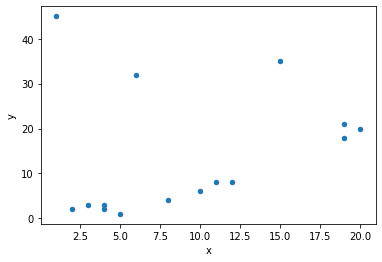

In [ ]:
df.plot.scatter(x='x', y='y', colormap='rainbow')

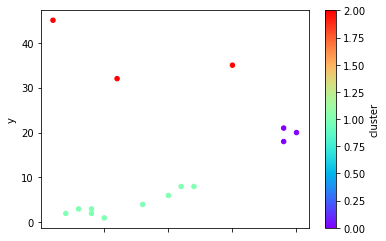

In [10]:
res_df.plot.scatter(x='x', y='y', c='cluster', colormap='rainbow')